<a href="https://colab.research.google.com/github/timluis/WeatherAssignment_ds4geo/blob/main/WeatherAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What it is like to live in Tehran and Singapore? 

Having the possibility to move either to Singapore or Tehran, where should I go? There a lot of things to keep in mind - the job, the culture, the landscape, the food, and the language. But maybe one of the most important things is the weather. Is it freezing? Is it always raining? Do I have to stay inside to flee the heat 90% of the time? So to help me with this decision, let's look at some weather data from the past four years:

In [ ]:
# import needed libraries 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime 
import os
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcol
from matplotlib.cm import ScalarMappable


### Define functions:


In [ ]:
# set to default style (makes plots nice if you use dark-theme in colab)
plt.style.use("default")

# define functions to read data, return the number of raindays, resample and plot a climate diagram

def read_data(city):
    """ Function to read meteo data from the GitHub repository 
      city:string
      returns: pandas DataFrame"""

    url= 'https://raw.githubusercontent.com/ds4geo/ds4geo/master/data/timeseries/meteo/'
    # read data if exists otherwise return an exception
    try:
        df = pd.read_csv(os.path.join(url+city+'_weather_2015-19.csv'))
    except Exception as e:
        return print(e, city + ' not available')

    #change data column to datetime object and set to index
    df.date = pd.to_datetime(df.date)
    df.set_index('date',inplace=True)
    #drop and rename unused columns
    df.drop(columns=['month','month-year','year'],inplace=True)
    df.columns = ['temp','min_temp','max_temp','pres','RH','wind','precip']
    return df

def resample(df,rule):
    """Function to resample the dataframe based on a ceratin rule
    df: DataFrame
    rule:string ['d': dayliy,'m':monthly,'y':yearly]"""
    df=df.resample(rule).agg({'temp':np.mean,'min_temp':np.min,'max_temp':np.max,'pres':np.mean,'RH':np.mean,'wind':np.mean,'precip':np.sum})
    return df

def monthly_avg(df):
    """Function to calculate the mean values for every month from multiple years
    df: DataFrame """
    # resample the data to monthly values
    df = resample(df,'m')
    # calculate a mean for every month
    df_avg = pd.DataFrame.from_dict({month:df.loc[df.index.month == month].mean() for month in df.index.month[0:12]},orient='Index')
    # change the index to a datetime object
    df_avg.index = pd.to_datetime(df_avg.index,format="%m")
    return df_avg

def plot_walter_lieth(df,city,elev,ax=None):
    """Function to plot a walter-lieht diagram from a dataframe
    df: DataFrame
    city: string
    elev: int
    ax: list with matplotlib Axes objects"""

    # create a subplots if no axes is given
    if ax == None:
      fig,ax = plt.subplots(2,1,figsize=(5,8),sharex=True)
      plt.subplots_adjust(hspace=0)
        
    # both subplots have two y-axis
    ax1 = ax[0]
    ax2 = ax1.twinx()
    ax3 = ax[1]
    ax4 = ax3.twinx()

    # plot temperature and precipitation
    ax3.plot(df.index,df.temp,color='red',label='Temperature')
    ax4.plot(df.index,df.precip,color='slateblue',label='Precipitation')
    ax2.plot(df.index,df.precip,color='slateblue',label='Precipitation')

    # set the ylim 
    ax3.set_ylim(-5,50)
    ax4.set_ylim(ax3.get_ylim()[0]*2,ax3.get_ylim()[1]*2)
    ax1.set_ylim(50,60)
    ax2.set_ylim(ax4.get_ylim()[1],ax1.get_ylim()[1]*10)

    # set the x-axis label
    # decrease the size of the second plot to half the height and get rid of the top/bottom spines
    for axes in [ax1,ax2,ax3,ax4]:
        axes.xaxis.set_major_locator(mdates.MonthLocator())
        axes.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
        box=axes.get_position()
        if axes.bbox.bounds[1] > ax3.bbox.bounds[1]:
            axes.spines['bottom'].set_visible(False)
            axes.set_position([box.x0, box.y0, box.width , box.height /2])
        else:
            axes.spines['top'].set_visible(False)

    # add fill between the lines
    ax3.fill_between(df.index,df.temp,df.precip/2,
                        edgecolor="slateblue",
                        where=df.temp < df.precip,
                        hatch='||',
                        facecolor='none',
                        alpha=0.3,
                        interpolate=True)
    ax2.fill_between(df.index,100,df.precip,
                        color="slateblue",
                        where=(df.temp < df.precip) & (df.precip > 100),
                        alpha=0.8,
                        interpolate=True)
    ax3.fill_between(df.index,df.temp,df.precip/2,
                        edgecolor="red",
                        where=df.temp > df.precip,
                        hatch='||',
                        facecolor='none',
                        alpha=0.3,
                        interpolate=True)
    # set the ticks for the changed scale 
    max = df.precip.max()
    max -= max % -100
    ax2.set_yticks(range(200,int(max)+100,100))

    
    ax1.tick_params(left=False,labelleft=False)
    ax3.set_ylabel('Temperature [°C]')
    ax4.set_ylabel('Precipitation [mm]')

    ax3.axhline(50,color="black",zorder=5)

    ax1.set_title(city+'\n' + '('+str(elev)+' m)',fontsize=10)
    ax2.text(0,1.1,str(round(df.temp.mean(),2))+' °C',transform=ax2.transAxes)
    ax2.text(1,1.1,str(int(df.precip.sum()))+' mm',transform=ax2.transAxes,ha='right')


def raindays(df,data_dict={}):
    """ Function to caluclate the amount of rain days for every year
    df: DataFrame (precipitation column named: precip)
    data_dict: dict """

    # made two lines out of one to increase readability both work
    #data_dict = {'raindays':{year:len(df[str(year)].loc[df.precip>0]) for year in df.index.year}}

    # select all values where precipitation is present
    precip = df.loc[df.precip>0]
    # loop over every year in the dataframe and count the days with precipitation
    data_dict = {'raindays':{year:len(precip[str(year)]) for year in precip.index.year}}

    # calculate the mean from all years
    data_dict['raindays']['mean']=sum(data_dict['raindays'].values())/len(data_dict['raindays'].values())

    return data_dict

## Read the weather data:


In [ ]:
# read data 
thr = read_data('Tehran')
sg = read_data('Singapore')

In [ ]:
# calculate the monthly average for all years
thr_avg = monthly_avg(thr)
sg_avg = monthly_avg(sg)

## Plot the data:



So, first of all, let us get a general overview of how the weather looks like in Tehran and Singapore:

In [ ]:
# set fontsize to 8 for all text
plt.rcParams.update({'font.size':8})

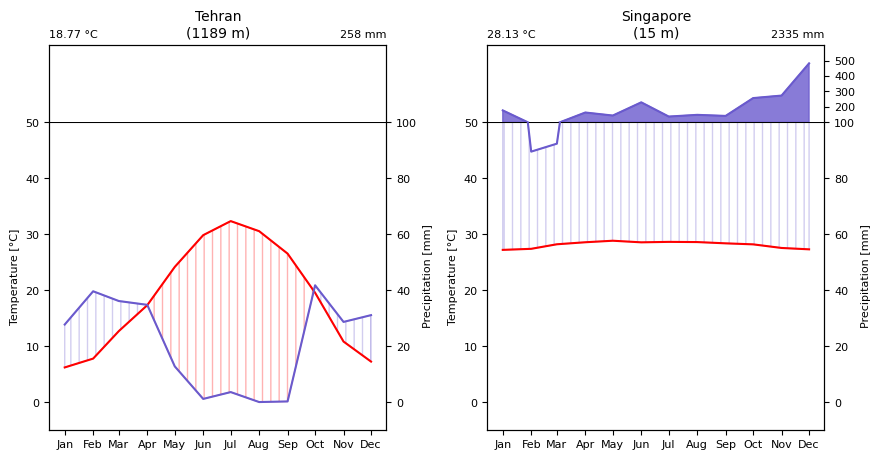

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8))
plt.subplots_adjust(hspace=0,wspace=0.3)
plot_walter_lieth(thr_avg,'Tehran',1189,ax=[ax1,ax3])
plot_walter_lieth(sg_avg,'Singapore',15,ax=[ax2,ax4])

For this task, Walter-Lieth diagrams are useful as they give a good overview. They show dry (red-lines), humid (blue-lines) and, wet (blue-filled) periods. The numbers on top of the y-axis show the annual mean temperature and the annual precipitation. Above 100 mm of precipitation, there is a change in scale (from 2 mm/°C to 20 mm/°C) for better visualization of large precipitation amounts.

As these diagrams show, there is a big difference between living in Singapore or Tehran. There is not only a prominent mean air temperature difference of about 10 °C, but there's also a yearly precipitation difference of over 2000 mm.  Other than that, there is almost no temperature difference throughout the year in Singapore. And it seems to be pretty hot all year round in Singapore. In contrast, there is a significant temperature change between summer and winter in Tehran. So let's summarize: Singapore is mainly hot and wet. Tehran is mostly dry and has large temperature differences throughout the year.

The plots already showed that, in general, there is a lot more rain in Singapore than in Tehran. But what about the days where it is actually raining? This might be a substantial aspect of where I want to live.

In [ ]:
thr_dict = raindays(thr)
sg_dict = raindays(sg)

print('Tehran:')
for k,v in thr_dict['raindays'].items():
  if k != "mean":
    print('There were',v,'rainy days in',str(k)+'.')
  else:
    print('On average: ',v,'rainy days.')

print('\nSingapore:')
for k,v in sg_dict['raindays'].items():
  if k != "mean":
    print('There were',v,'rainy days in',str(k)+'.')
  else:
    print('On average:',v,'rainy days.')

Tehran:
There were 62 rainy days in 2015.
There were 47 rainy days in 2016.
There were 49 rainy days in 2017.
There were 70 rainy days in 2018.
There were 54 rainy days in 2019.
On average:  56.4 rainy days.

Singapore:
There were 124 rainy days in 2015.
There were 180 rainy days in 2016.
There were 202 rainy days in 2017.
There were 224 rainy days in 2018.
There were 178 rainy days in 2019.
On average: 181.6 rainy days.


It seems that my first assumption is right. The chance to get drenched is much higher in Singapore than in Tehran because there are more than three times as many rain days.



Still, I don't want to make a decision based on just a few red and blue lines. So I asked two locals, Anoosh from Tehran and Lee from Singapore, to record important weather events through 2019.

## Define more functions:

In [ ]:
 def weather_radial(df,city,events=[],cbar_loc=(-0.3,0.13),leg_loc=(1,-0.11),year='2019'):
    """ Plot a polar plot with daily temparature and precipitation
    df: pandas DataFrame
    city: string
    events: list of dicts (like:{'name':'event name', 'day':dayofyear, 'shift':int}, default empty)
    cbar_loc: tuple (position of colorbar default lower right)
    leg_loc: tuple (position of legend default lower right)  """

    # set font siez to 8  
    plt.rcParams.update({'font.size':8})
    
    # create figure and add a polar axes with zero location N
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")

    # create a array with days converted to radians
    tnorm=np.linspace(0,np.radians(360),365)

    y_mean = df.loc[year]['temp']
    y_max = df.loc[year]['max_temp']
    y_min = df.loc[year]['min_temp']
    precip = df.loc[year]['precip']
    if len(df.loc[year]) < 365:
      y_mean = np.append(y_mean,np.full(365-len(df.loc[year]),np.nan))
      y_max = np.append(y_max,np.full(365-len(df.loc[year]),np.nan))
      y_min = np.append(y_min,np.full(365-len(df.loc[year]),np.nan))
      precip = np.append(precip,np.full(365-len(df.loc[year]),np.nan))



    # set the scale for the colorbar
    normal=plt.Normalize(-5,40)

    # plot a bar plot between min and max temp with colormap
    bar=ax.bar(tnorm,y_max-y_min,width=tnorm[1]-tnorm[0],bottom=y_min,color=plt.cm.jet(normal(y_mean)),zorder=4,alpha=0.7)

    # plot a scatter at the mean temp with the size based on the precipitation
    scatter=ax.scatter(tnorm,y_mean,color='blue',alpha=0.2,marker='o',s=precip*30,zorder=3,edgecolors='None',label='Precip')

    #set label positions
    ax.set_rlabel_position(0)

    # create month xticks
    month_ls = [month[0:3] for month in df.index.month_name().unique()]
    ax.set_xticks([np.radians(deg) for deg in np.arange(0,360,30)])

    # rotate the x labels according to their position and place them in the middle
    for label,pos_rad in zip(month_ls,ax.get_xticks()):
      lab = ax.text(pos_rad+np.radians(15),52,label,ha='center',va='center',color='grey')
      lab.set_rotation(-np.degrees(pos_rad)-15)

    # set the ticks and grids and remove the outer circle
    ax.xaxis.set_tick_params(direction='out',length=10,width=1,top=True,color="grey")
    ax.spines['polar'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_rgrids([-10,0,10,20,30,40,50],labels=['','0 °C','','20 °C','','40 °C',''],color='grey',angle=1)
    ax.yaxis.grid(True,alpha=0.3)
    ax.xaxis.grid(True,color='grey',linewidth=1,alpha=0.3)

    # place the city name in the middle
    ax.text(0,-10,city,ha='center',va='center',color='grey',fontsize=14,bbox=dict(facecolor='white',linewidth=0))

    
    # add every event with an arrow and the text outside of the plot
    for event in events:
      ax.annotate(event['name'],(tnorm[event['day']],y_mean[event['day']]),
                  xytext=(tnorm[event['day']]+event['shift'],65),
                  arrowprops={'arrowstyle':'-'},
                  va='center',ha='center',
                  zorder=5,
                  bbox=dict(facecolor='grey',edgecolor='none',alpha=0.1,boxstyle='round,rounding_size=0.7'))
    
    # get the handles and labels from the sactter plot
    handles,labels = scatter.legend_elements(prop='sizes',func=lambda s:s/30,num=[5,10,20],fmt="{x:.0f} mm",color='blue',alpha=0.3)

    # create a legend and set the text color 
    legend=ax.legend(handles,labels,labelspacing=1.8,handletextpad=1.3,loc=leg_loc,title='Precipitation',frameon=False)
    plt.setp(legend.get_texts(), color='grey')
    legend._legend_title_box._text.set_color('grey')

    # set the text color from the colorbar
    cbar=plt.colorbar(ScalarMappable(cmap=plt.cm.jet,norm=normal),aspect=30,shrink=0.3,pad=0.2,label='Temperature [°C]',anchor=cbar_loc)
    cbar.set_label('Temperature [°C]',color='grey')
    cbar.ax.yaxis.set_tick_params(color='grey')
    cbar.outline.set_edgecolor('grey')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='grey')

## Plot the yearly data:

In [ ]:
events_sg = [{'name':"'Finally! It looks like I don't \n need an umbrella for a couple of days!'",
              'day':datetime.date(2019,7,3).timetuple().tm_yday,'shift':0}, 
             {'name':"\u266B I'm singing in the rain,... \u266B",
              'day':datetime.date(2019,3,26).timetuple().tm_yday,'shift':0},
             {'name':"'What a weird summer. \n I never thought I would say that... \n but I kinda miss the rain'",
              'day':datetime.date(2019,9,5).timetuple().tm_yday,'shift':0},
             {'name': "'If I got a dollar for every rain drop, \n I would be a billionaire...'",
              'day':datetime.date(2019,12,8).timetuple().tm_yday,'shift':-0.2},
             {'name': "'Goodbye 2019 & your 365 warm & humid days - \n Hello 2020 & another 365 warm & humid days!",
              'day':datetime.date(2019,12,30).timetuple().tm_yday,'shift':0}]

So Lee collected a lot of events for me, and I plotted the most important ones next to the temperature and the precipitation in 2019. Let's have a look:

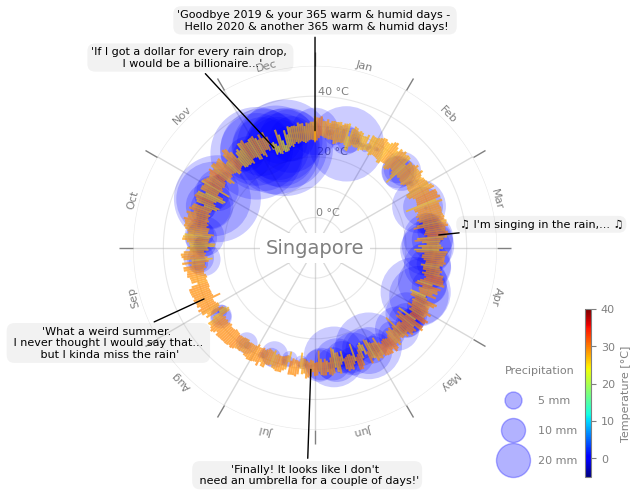

In [ ]:
weather_radial(sg,'Singapore',events=events_sg)

In [ ]:
events_thr = [{'name':"'Did I say I'm dying last month? \n Well, now I am actually dead. \n And there's no end in sight.",
               'day':datetime.date(2019,7,15).timetuple().tm_yday,'shift':0.2},
              {'name':"\u266B Bless the rains \n down in ... \u266B",
              'day':datetime.date(2019,10,22).timetuple().tm_yday,'shift':-0.3},
              {'name': "'Brace yourself. Winter is coming'",
              'day':datetime.date(2019,11,1).timetuple().tm_yday,'shift':0},
              {'name': "'The best thing about a really cold winter day is that \n the Mount Damavand looks so close!'",
              'day':datetime.date(2019,1,10).timetuple().tm_yday,'shift':0},
              {'name': "'I'm dying... it's so hot'",
                'day':datetime.date(2019,6,7).timetuple().tm_yday,'shift':0},
              {'name': "'Hello Spring!!! \n Finally, winter is over!'",
                'day':datetime.date(2019,4,15).timetuple().tm_yday,'shift':-0.2},
              {'name': "'Oh, nevermind...'",
                'day':datetime.date(2019,4,23).timetuple().tm_yday,'shift':0}]

For comparison, I did the same with the data recorded from Anoosh:

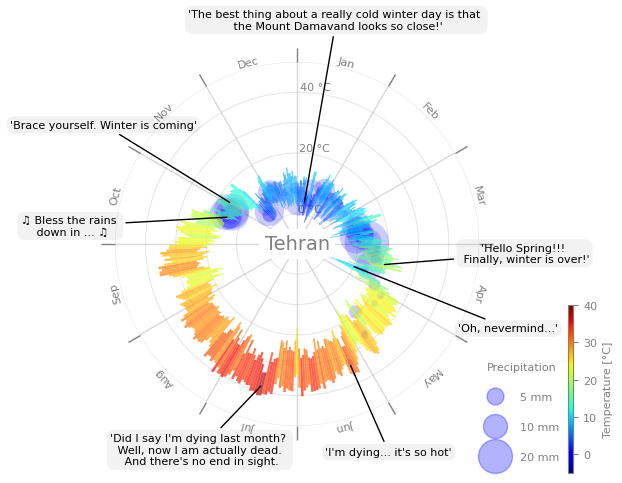

In [ ]:
weather_radial(thr,'Tehran',events=events_thr)

After receiving all the information and anecdotes from Anoosh and Lee, I thought about the two cities a lot. Can I cope with the hot summers in Tehran? Is carrying an umbrella my new everyday activity? I was puzzled. And after a while, I realized there is really just one option left for me:

I am packing my bags and fly off to...



# **HAWAII**

<img src="https://media.giphy.com/media/Tkw0XugFdX5W8/giphy.gif">

